![NeuronUnit Logo](https://raw.githubusercontent.com/scidash/assets/master/logos/neuronunit-logo-text.png)
# Chapter 3
Back to [Chapter 2](chapter2.ipynb)

In the second chapter we tested a real ion channel model using data from the [OpenWorm](http://openworm.org) project.  Here we'll test a reduced neuron model using data from the [NeuroElectro](http://neuroelectro.org) project and from the [Allen Brain Institute Cell Types](http://celltypes.brain-map.org) database.  
### We'll test an Izhikevich model against data from a Layer V pyramidal cell in primary visual cortex

In [1]:
%matplotlib inline
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import quantities as pq
import sciunit
import neuronunit
from neuronunit import aibs
from neuronunit.models.reduced import ReducedModel

In [2]:
import quantities as pq
from neuronunit import tests as nu_tests, neuroelectro
neuron = {'nlex_id': 'nifext_50'} # Layer V pyramidal cell
tests = []

dataset_id = 354190013  # Internal ID that AIBS uses for a particular Scnn1a-Tg2-Cre 
                        # Primary visual area, layer 5 neuron.
    
# Obtain the empirical rheobase current from the Allen Brain Insitute Cell Types database.  
observation = aibs.get_observation(dataset_id,'rheobase')
rheobase_test = nu_tests.RheobaseTest(observation=observation)
tests += [rheobase_test]
    
test_class_params = [(nu_tests.InputResistanceTest,None),
                     (nu_tests.TimeConstantTest,None),
                     (nu_tests.CapacitanceTest,None),
                     (nu_tests.RestingPotentialTest,None),
                     (nu_tests.InjectedCurrentAPWidthTest,None),
                     (nu_tests.InjectedCurrentAPAmplitudeTest,None),
                     (nu_tests.InjectedCurrentAPThresholdTest,None)
                    ]

# Obtain all other parameters from neuroelectro.org.
for cls,params in test_class_params:
    observation = cls.neuroelectro_summary_observation(neuron)
    tests += [cls(observation,params=params)]
    
# A hook to update all tests after the RheobaseTest to use the rheobase current (to produce exactly one AP)
def update_amplitude(test,tests,score):
    rheobase = score.prediction['value']
    for test in tests[1:]:
        if 'Injected' in test.name:
            # Set current injection to just suprathreshold
            test.params['injected_square_current']['amplitude'] = rheobase*1.01 
    
hooks = {tests[0]:{'f':update_amplitude}}
suite = sciunit.TestSuite("vm_suite",tests,hooks=hooks)

Getting data values from neuroelectro.org
http://www.neuroelectro.org/api/1/nes/?e__name=Input+Resistance&nlex=nifext_50
Getting data values from neuroelectro.org
http://www.neuroelectro.org/api/1/nes/?e__name=Membrane+Time+Constant&nlex=nifext_50
Getting data values from neuroelectro.org
http://www.neuroelectro.org/api/1/nes/?e__name=Cell+Capacitance&nlex=nifext_50
Getting data values from neuroelectro.org
http://www.neuroelectro.org/api/1/nes/?e__name=Resting+membrane+potential&nlex=nifext_50
Getting data values from neuroelectro.org
http://www.neuroelectro.org/api/1/nes/?e__name=Spike+Half-Width&nlex=nifext_50
Getting data values from neuroelectro.org
http://www.neuroelectro.org/api/1/nes/?e__name=Spike+Amplitude&nlex=nifext_50
Getting data values from neuroelectro.org
http://www.neuroelectro.org/api/1/nes/?e__name=Spike+Threshold&nlex=nifext_50


### The Izhikevich model here is defined in an NeuroML2/LEMS file.  
### We will run it using the jNeuroML backend for simplicity, although this is *much* slower than the native NEURON backend.  

In [3]:
# This example is from https://github.com/OpenSourceBrain/IzhikevichModel.
DOCS_PATH = os.getcwd() # Assume this notebook is being executed from inside the neuronunit/docs directory.
assert DOCS_PATH.endswith('neuronunit/docs'), "Change the DOCS_PATH variable to the path to your neuronunit/docs directory"
LEMS_MODEL_PATH = os.path.join(DOCS_PATH,'data/NeuroML2/LEMS_2007One.xml')
model = ReducedModel(LEMS_MODEL_PATH,name='vanilla',backend='jNeuroML')

### Run a series of tests.  The RheobaseTest is run first to obtain the rheobase current to use in all the other tests.

In [4]:
score_matrix = suite.judge(model)

InvalidScoreError: Score for test 'RheobaseTest' is not of correct type. The test requires type RatioScore but NoneType was provided.

### Now we can sweep across a parameter (the resting potential) and run the same test suite on a model corresponding to each value of this parameter.

In [6]:
models = []
for vr in np.linspace(-80,-50,4):
    model = ReducedModel(LEMS_MODEL_PATH, 
                         name='V_rest=%dmV' % vr, 
                         attrs={'//izhikevich2007Cell':
                                    {'vr':'%d mV' % vr}
                               })
    #model.skip_run = True
    models.append(model)
suite.set_verbose(False) # Turn off most print statements.  
score_matrix = suite.judge(models)

Highest subthreshold current is 241.41 pA
Lowest suprathreshold current is 241.99 pA


Injected 300.0 pA current and got 50 spikes
Injected -0.0 pA current and got 0 spikes
Injected 150.0 pA current and got 8 spikes
Injected 75.0 pA current and got 0 spikes
Injected 112.5 pA current and got 0 spikes
Injected 131.25 pA current and got 2 spikes
Injected 121.875 pA current and got 0 spikes
Injected 126.5625 pA current and got 0 spikes
Injected 128.90625 pA current and got 0 spikes
Injected 130.078125 pA current and got 1 spikes
Injected 129.4921875 pA current and got 1 spikes
Highest subthreshold current is 128.91 pA
Lowest suprathreshold current is 129.49 pA


Injected 300.0 pA current and got 54 spikes
Injected -0.0 pA current and got 0 spikes
Injected 150.0 pA current and got 25 spikes
Injected 75.0 pA current and got 8 spikes
Injected 37.5 pA current and got 0 spikes
Injected 56.25 pA current and got 3 spikes
Injected 46.875 pA current and got 0 spikes
Injected 51.5625 pA current and got 0 spikes
Injected 53.90625 pA current and got 2 spikes
Injected 52.734375 pA current and got 1 spikes
Injected 52.1484375 pA current and got 1 spikes
Highest subthreshold current is 51.56 pA
Lowest suprathreshold current is 52.15 pA


Injected 300.0 pA current and got 54 spikes
Injected -0.0 pA current and got 0 spikes
Injected 150.0 pA current and got 30 spikes
Injected 75.0 pA current and got 16 spikes
Injected 37.5 pA current and got 9 spikes
Injected 18.75 pA current and got 5 spikes
Injected 9.375 pA current and got 1 spikes
Injected 4.6875 pA current and got 0 spikes
Injected 7.03125 pA current and got 0 spikes
Injected 8.203125 pA current and got 0 spikes
Injected 8.7890625 pA current and got 0 spikes
Highest subthreshold current is 8.79 pA
Lowest suprathreshold current is 9.38 pA


In [7]:
score_matrix.show_mean = True # Show the mean value across test scores. 
                              # The mean is computed using the sort_key attribute, which is in the range [0,1] for
                              # all Score types
score_matrix.sortable = True # Make the ScoreMatrix sortable (and searchable)
score_matrix

<IPython.core.display.Javascript object>

,Mean,RheobaseTest,InputResistanceTest,TimeConstantTest,CapacitanceTest,RestingPotentialTest,InjectedCurrentAPWidthTest,InjectedCurrentAPAmplitudeTest,InjectedCurrentAPThresholdTest
V_rest=-80mV,0.342,Ratio = 1.86,Z = -1.04,Z = -1.49,Z = 0.11,Z = -2.58,Z = -1.54,Z = -0.72,Z = -1.94
V_rest=-70mV,0.384,Ratio = 1.00,Z = -0.87,Z = -1.46,Z = 0.12,Z = -2.46,Z = -1.54,Z = -0.76,Z = -1.90
V_rest=-60mV,0.356,Ratio = 0.40,Z = -0.53,Z = -1.42,Z = 0.17,Z = -2.33,Z = -1.54,Z = -0.80,Z = -1.86
V_rest=-50mV,0.296,Ratio = 0.07,Z = 0.29,Z = -1.29,Z = 0.28,Z = -2.20,Z = -1.54,Z = -0.85,Z = -1.81


### Let's take a look at a sweep from one of these models ($V_{rest} = -55 mV$) obtained at the rheobase current.  

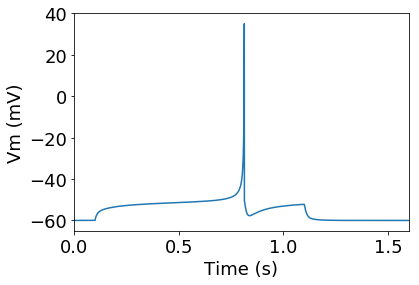

In [10]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 18
score_matrix['RheobaseTest']['V_rest=-60mV'].plot_vm() # Plot the rheobase current from the model with V_rest = -60 mV